In [1]:
"""
Name: con_benchmark.ipynb
Authors: Stephan Meighen-Berger
Constructs the benchmark plots to compare with the other models
"""
%load_ext autoreload
%autoreload 2

In [2]:
 # General imports
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd
from tqdm import tqdm

In [3]:
# Adding path to module
sys.path.append("../")

In [4]:
# picture path
PICS = '../pics/'

In [5]:
# Module imports
from contagion import Contagion, config

In [6]:
# Options
# General
config['general']['trace spread'] = True
# Population
config['population']['population size'] = 9999
config['population']['social circle pdf']["mean"] = 40
config['population']['social circle interactions pdf']["mean"] = 18
config["population"]['population class'] = 'HomogeneousPopulation'
# HomogeneousPopulation AccuratePopulation
# Infection
config['infection']['infected'] = 1
config['infection']['infection probability pdf']['mean'] = 4.
config['infection']['infection probability pdf']['sd'] = 2.42
config['infection']['infection probability pdf']['max_val'] = 0.15
config['infection']["hospitalization probability pdf"]['mean'] = 0.5

In [7]:
stats_arr = []
t_s_arr = []
for seed in tqdm(range(100)):
    config['general']["random state seed"] = seed
    # Creating a contagion object
    contagion = Contagion()
     # Storing the solutions
    contagion.sim()
    stats_arr.append(pd.DataFrame(contagion.statistics))
    t_s_arr.append(contagion.trace_infection)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [07:24<00:00,  4.74s/it]


In [8]:
# Averaging
stats = {}
for key in stats_arr[0].keys():
    stats[key] = np.average(np.array([
        stats_arr[i][key]
        for i in range(len(stats_arr))
    ]), axis=0)

In [9]:
# R_eff_steph
r_eff_arr_steph = []
for t_s in t_s_arr:
    try:
        edges_inf = np.unique(np.array(np.squeeze(np.hstack([i for i in t_s])).tolist()), axis=0)
        unique, counts = np.unique(edges_inf[:, 0], return_counts=True)
        counter_dic = dict(zip(unique, counts / 2))
        day_to_day_infector = np.array([[i, np.unique(t_s[i][0][:, 0])] for i in range(config['general']["simulation length"])])
        r_eff_arr_steph.append(np.nan_to_num(np.array([
            np.average([counter_dic[day_inf[1][j]] if len(day_inf[1]) > 0 else 0 for j in range(len(day_inf[1]))])
            for day_inf in day_to_day_infector
        ])))
    except:
        continue
r_eff_steph = np.average(r_eff_arr_steph, axis=0)

C:\Users\steph\Anaconda3\lib\site-packages\numpy\lib\function_base.py:390: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\steph\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [10]:
newly_recovered = np.diff(stats['is_recovered'])
newly_recovered = np.insert(newly_recovered, 0, 0)

In [11]:
def Unique(array, orderby='first'):
    array = np.asarray(array)
    order = array.argsort(kind='mergesort')
    array = array[order]
    diff = array[1:] != array[:-1]
    if orderby == 'first':
        diff = np.concatenate([[True], diff])
    elif orderby == 'last':
        diff = np.concatenate([diff, [True]])
    else:
        raise ValueError
    uniq = array[diff]
    index = order[diff]
    return uniq[index.argsort()]

In [12]:
# R_eff_tina
r_eff_arr_tina = []
for t_s in t_s_arr:
    try:
        lower_id = 0
        edges_inf = np.unique(np.array(np.squeeze(np.hstack([i for i in t_s])).tolist()), axis=0)
        unique, counts = np.unique(edges_inf[:, 0], return_counts=True)
        counter_dic = dict(zip(unique, counts / 2))
        sorted_infectors = Unique(np.hstack(np.array([day[0, :,0] for day in t_s])))
        r_eff_tina_tmp = []
        for i in range(config['general']["simulation length"]):
            today_recovered = newly_recovered[i]
            upper_id = int(today_recovered + lower_id)
            todays_recovered_infectors = sorted_infectors[lower_id:upper_id]
            these_infected = np.sum(np.array([counter_dic[infec] for infec in todays_recovered_infectors]))
            lower_id = upper_id
            r_eff_tina_tmp.append(these_infected / len(todays_recovered_infectors))
        r_eff_tina_tmp = np.nan_to_num(np.array(r_eff_tina_tmp))
        r_eff_arr_tina.append(r_eff_tina_tmp)
    except:
        continue
r_eff_tina = np.average(r_eff_arr_tina, axis=0)

C:\Users\steph\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [13]:
# Fetching representative result
maxima_id = np.array([np.argmax(stats_arr[i]['is_infected']) for i in range(len(stats_arr))])
average_max_id = np.argmax(stats['is_infected'])
nearest_id = (np.abs(maxima_id - average_max_id)).argmin()
run_id = nearest_id

C:\Users\steph\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return bound(*args, **kwds)


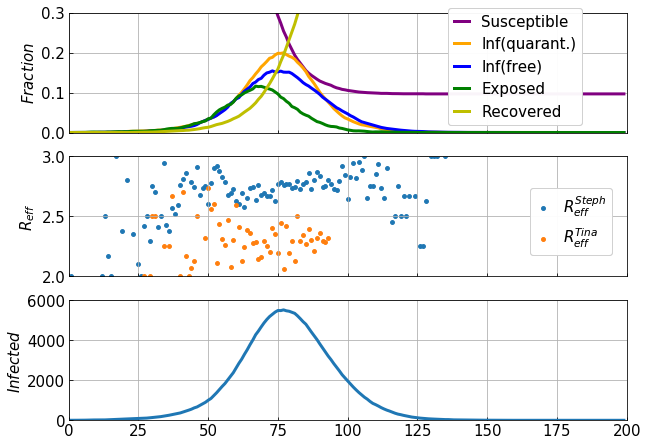

In [17]:
# Plotting standards
std_size = 10.
fontsize = 15.
lw=3.
h_length=1.
figure, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(std_size, std_size * 6. / 8.), sharex=True)
colors = ['#fdcc8a',
          '#fc8d59',
          '#d7301f']
# ---------------------------------------------------------------------------------
# Infections per time step
ax1.plot(contagion.t,
         (config['population']['population size'] - stats_arr[run_id]['is_recovered'] -
          stats_arr[run_id]['is_infected']) /
         config['population']['population size'],
         lw=lw, label='Susceptible', color='purple')
ax1.plot(contagion.t, stats_arr[run_id]['is_hospitalized'] / config['population']['population size'],
         lw=lw, label='Inf(quarant.)', color='orange')
ax1.plot(contagion.t, (stats_arr[run_id]['is_incubation'] + stats['is_infectious']) / config['population']['population size'],
         lw=lw, label='Inf(free)', color='b')
ax1.plot(contagion.t, (stats_arr[run_id]['is_latent']) / config['population']['population size'],
         lw=lw, label='Exposed', color="g")
ax1.plot(contagion.t, stats_arr[run_id]['is_recovered'] / config['population']['population size'],
         lw=lw, label='Recovered', color='y')
# ax1.set_xlim(0, 200)
ax1.set_ylim(0., 0.3)
ax1.set_xscale('linear')
ax1.set_yscale('linear')
# ax1.set_xlabel(r't [Days]', fontsize=fontsize)
ax1.set_ylabel(r'$Fraction$', fontsize=fontsize)
ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
h, l = ax1.get_legend_handles_labels()
lgd1 = ax1.legend(h,l, loc=9, bbox_to_anchor=(0.8, +1.1),
                  ncol=1, fontsize=fontsize, handlelength=h_length,
                  fancybox=True, frameon=True)
ax1.add_artist(lgd1)
ax1.grid(True)
# ---------------------------------------------------------------------------------
# The effective R value
ax2.scatter(contagion.t, r_eff_arr_steph[run_id], s=lw * 5, label=r'$R_{eff}^{Steph}$')
ax2.scatter(contagion.t, r_eff_arr_tina[run_id], s=lw * 5, label=r'$R_{eff}^{Tina}$')
ax2.set_ylim(2., 3.)
ax2.set_xscale('linear')
ax2.set_yscale('linear')
# ax1.set_xlabel(r't [Days]', fontsize=fontsize)
ax2.set_ylabel(r'$R_{eff}$', fontsize=fontsize)
ax2.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax2.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
h, l = ax2.get_legend_handles_labels()
lgd1 = ax2.legend(h,l, loc=9, bbox_to_anchor=(0.9, +0.8),
                  ncol=1, fontsize=fontsize, handlelength=h_length,
                  fancybox=True, frameon=True)
ax2.add_artist(lgd1)
ax2.grid(True)
# ---------------------------------------------------------------------------------
# The number of infected people
ax3.plot(contagion.t, stats_arr[run_id]['is_infected'], lw=lw)
ax3.set_xlim(0, 200)
ax3.set_ylim(0., 6000)
ax3.set_xscale('linear')
ax3.set_yscale('linear')
# ax1.set_xlabel(r't [Days]', fontsize=fontsize)
ax3.set_ylabel(r'$Infected$', fontsize=fontsize)
ax3.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax3.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
ax3.grid(True)
plt.show()

In [15]:
figure.savefig(PICS + "Contagion_Benchmark.png",
               bbox_inches='tight')

In [16]:
# np.savetxt('Exposed.csv', stats_arr[run_id]['is_latent'])
# np.savetxt('Susceptible.csv', config['population']['population size'] - stats_arr[run_id]['is_recovered'] -
#           stats_arr[run_id]['is_infected'])
# np.savetxt('Infectious.csv', stats_arr[run_id]['is_hospitalized'] +
#            stats_arr[run_id]['is_incubation'] + stats_arr[run_id]['is_infectious'])
# np.savetxt('Recovered.csv', stats_arr[run_id]['is_recovered'])